# Evaluación de XGBoost con Parámetros Optimizados

Este notebook evalúa el rendimiento de un modelo XGBoost utilizando los parámetros óptimos encontrados mediante Optuna. Calcularemos y mostraremos las métricas clave: MAE, RMSE y R².

In [1]:
# 1. Configuración del Entorno
import sys
import os
from pathlib import Path

# Añadir src al path para importar los módulos
sys.path.append(str(Path().resolve().parent / 'src'))

# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Configurar el estilo de las gráficas
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [2]:
# 2. Carga y Preparación de Datos
from src.model import preparar_datos_pipeline, train_evaluate_xgboost

# Obtener los datos procesados
try:
    # Intentamos usar la versión extendida de la función que devuelve también metadatos
    X_train, y_train, X_test, y_test, archivo_usado, fecha_corte, columna_target = preparar_datos_pipeline(
        parquet_file='ts_df_bolleria_20250803.parquet',
        split_date='2025-03-03',
        target='base_imponible'
    )
    print(f"Usando archivo: {archivo_usado}")
    print(f"Fecha de corte: {fecha_corte}")
    print(f"Columna target: {columna_target}")
except ValueError:
    # Si la función no devuelve metadatos, usamos la versión simple
    X_train, y_train, X_test, y_test = preparar_datos_pipeline(
        parquet_file='ts_df_bolleria_20250803.parquet',
        split_date='2025-03-03',
        target='base_imponible'
    )

# Mostrar información sobre los datos
print(f"\nDatos de entrenamiento: {X_train.shape[0]} filas, {X_train.shape[1]} columnas")
print(f"Datos de prueba: {X_test.shape[0]} filas, {X_test.shape[1]} columnas")

# Verificar columnas con fechas (que podrían causar problemas con XGBoost)
datetime_cols = [col for col in X_train.columns if pd.api.types.is_datetime64_any_dtype(X_train[col])]
if datetime_cols:
    print(f"\nColumnas con fechas detectadas: {datetime_cols}")
    print("Eliminando columnas de fecha para evitar problemas con XGBoost...")
    X_train = X_train.drop(columns=datetime_cols)
    X_test = X_test.drop(columns=datetime_cols)

Usando archivo: ts_df_bolleria_20250803.parquet
Fecha de corte: 2025-03-03
Columna target: base_imponible

Datos de entrenamiento: 58 filas, 8 columnas
Datos de prueba: 15 filas, 8 columnas

Columnas con fechas detectadas: ['week_start']
Eliminando columnas de fecha para evitar problemas con XGBoost...


In [3]:
# 3. Definición de los Mejores Parámetros encontrados por Optuna
# Usamos los parámetros proporcionados, pero con valores concretos (no trial.suggest_*)

# Estos son los valores concretos obtenidos en el notebook anterior
best_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',  # Valor optimizado: gbtree
    'lambda': 1.5217227415395248e-07,  # Valor optimizado
    'alpha': 3.805804544409099e-06,  # Valor optimizado
    'subsample': 0.2068525521593345,  # Valor optimizado
    'colsample_bytree': 0.8857508899692184,  # Valor optimizado
    'n_estimators': 51,  # Valor optimizado
    'max_depth': 7,  # Valor optimizado
    'learning_rate': 0.08962161965694515,  # Valor optimizado
    'random_state': 42  # Para reproducibilidad
}

# Mostrar los parámetros optimizados
print("Parámetros optimizados para XGBoost:")
for param, value in best_params.items():
    print(f"  - {param}: {value}")

Parámetros optimizados para XGBoost:
  - objective: reg:squarederror
  - booster: gbtree
  - lambda: 1.5217227415395248e-07
  - alpha: 3.805804544409099e-06
  - subsample: 0.2068525521593345
  - colsample_bytree: 0.8857508899692184
  - n_estimators: 51
  - max_depth: 7
  - learning_rate: 0.08962161965694515
  - random_state: 42


In [4]:
# 4. Entrenamiento del Modelo XGBoost con los parámetros optimizados
# Creamos el modelo con los parámetros optimizados
model = xgb.XGBRegressor(**best_params)

# Entrenamos el modelo
print("Entrenando modelo XGBoost con parámetros optimizados...")
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)

print("¡Entrenamiento completado!")

Entrenando modelo XGBoost con parámetros optimizados...
¡Entrenamiento completado!


In [5]:
# 5. Evaluación del Modelo - Cálculo de métricas MAE, RMSE y R²

# Realizar predicciones en conjunto de entrenamiento
y_train_pred = model.predict(X_train)

# Realizar predicciones en conjunto de prueba
y_test_pred = model.predict(X_test)

# Calcular métricas para conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Calcular métricas para conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Crear un diccionario con todas las métricas
metrics = {
    'Conjunto': ['Entrenamiento', 'Prueba'],
    'MAE': [mae_train, mae_test],
    'RMSE': [rmse_train, rmse_test],
    'R²': [r2_train, r2_test]
}

# Convertir a DataFrame para mejor visualización
metrics_df = pd.DataFrame(metrics)

# Mostrar resultados
print("Métricas de evaluación del modelo XGBoost con parámetros optimizados:")
print(metrics_df.to_string(index=False))

# Métricas detalladas para conjunto de prueba (las solicitadas)
print("\n============= MÉTRICAS EN CONJUNTO DE PRUEBA =============")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Métricas de evaluación del modelo XGBoost con parámetros optimizados:
     Conjunto       MAE       RMSE       R²
Entrenamiento 49.487043  79.397055 0.961008
       Prueba 88.693206 126.383989 0.686418

============= MÉTRICAS EN CONJUNTO DE PRUEBA =============
MAE: 88.6932
RMSE: 126.3840
R²: 0.6864


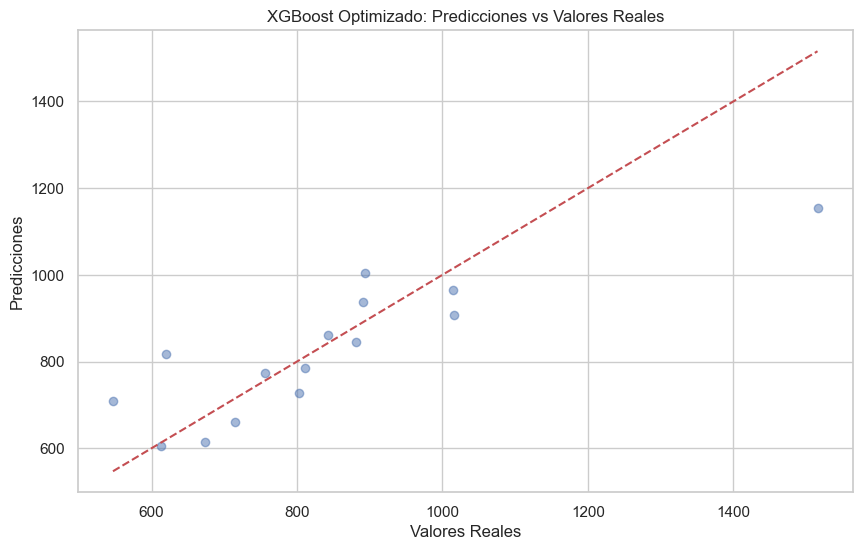

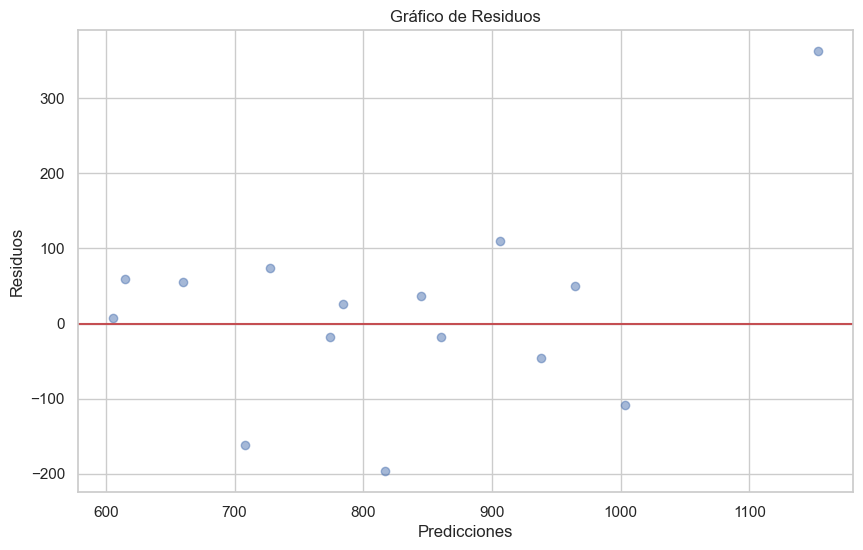

<Figure size 1200x800 with 0 Axes>

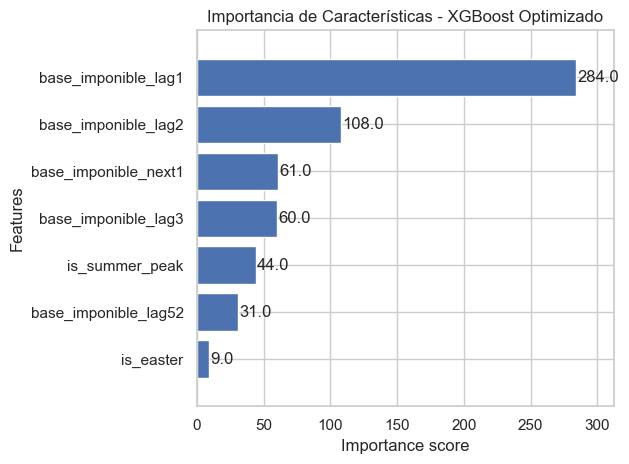

In [6]:
# 6. Visualización de Resultados

# 6.1 Gráfico de Predicciones vs Valores Reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('XGBoost Optimizado: Predicciones vs Valores Reales')
plt.grid(True)
plt.show()

# 6.2 Gráfico de Residuos
residuos = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)
plt.show()

# 6.3 Gráfico de Importancia de Características
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, height=0.8, max_num_features=20)
plt.title('Importancia de Características - XGBoost Optimizado')
plt.tight_layout()
plt.show()

In [7]:
# 7. Guardado del Modelo y Resultados
import os
from datetime import datetime

# Crear directorio para modelos si no existe
os.makedirs('models', exist_ok=True)

# Nombre del archivo con fecha y métricas principales
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_filename = f"models/xgboost_optimizado_mae{mae_test:.2f}_r2{r2_test:.2f}_{timestamp}.pkl"

# Guardar modelo
joblib.dump(model, model_filename)
print(f"Modelo guardado en: {model_filename}")

# Guardar métricas en CSV
metrics_df.to_csv(f"models/metricas_xgboost_optimizado_{timestamp}.csv", index=False)
print(f"Métricas guardadas en: models/metricas_xgboost_optimizado_{timestamp}.csv")

# Resumen final
print("\n========== RESUMEN DE RESULTADOS ==========")
print(f"MAE (Error Absoluto Medio): {mae_test:.4f}")
print(f"RMSE (Error Cuadrático Medio): {rmse_test:.4f}")
print(f"R² (Coeficiente de Determinación): {r2_test:.4f}")
print("==========================================")

Modelo guardado en: models/xgboost_optimizado_mae88.69_r20.69_20250816_1118.pkl
Métricas guardadas en: models/metricas_xgboost_optimizado_20250816_1118.csv

========== RESUMEN DE RESULTADOS ==========
MAE (Error Absoluto Medio): 88.6932
RMSE (Error Cuadrático Medio): 126.3840
R² (Coeficiente de Determinación): 0.6864
